#Set up Environment

In [1]:
!nvidia-smi

Wed Aug  7 16:09:50 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
!git clone https://github.com/Omid-Nejati/MedViT.git
%cd /content/MedViT

Cloning into 'MedViT'...
remote: Enumerating objects: 176, done.
remote: Counting objects: 100% (175/175), done.
remote: Compressing objects: 100% (106/106), done.
remote: Total 176 (delta 87), reused 134 (delta 61), pack-reused 1
Receiving objects: 100% (176/176), 820.48 KiB | 14.92 MiB/s, done.
Resolving deltas: 100% (87/87), done.
/content/MedViT


In [3]:
pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.4/88.4 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (

In [4]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

import torchvision.utils
from torchvision import models
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torchsummary import summary

from tqdm import tqdm
import medmnist
from medmnist import INFO, Evaluator

import torchattacks
from torchattacks import PGD, FGSM

#Model

In [5]:
# Function to set the random seed
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

##ECB+EATFormer

In [6]:
from functools import partial
import math
import torch
import torch.utils.checkpoint as checkpoint

from einops import rearrange, reduce, repeat
from torchvision.ops import DeformConv2d
import torch.nn.functional as F

from einops import rearrange
from timm.models.layers import DropPath, trunc_normal_
from timm.models.registry import register_model

from torch import nn

init_alpha_value = 1e-3
init_scale_values = 1e-4
NORM_EPS = 1e-5

def merge_pre_bn(model):
    """Gộp các lớp BatchNorm vào các lớp Conv2d trước chúng."""
    for module in model.modules():
        if isinstance(module, nn.BatchNorm2d):
            # Lấy lớp Conv2d liền kề trước lớp BatchNorm
            conv = module.previous_module  # Bạn cần sửa phần này tùy thuộc vào cấu trúc mô hình của bạn
            if isinstance(conv, nn.Conv2d):
                with torch.no_grad():
                    # Gộp trọng số BatchNorm vào Conv2d
                    conv.weight.data = conv.weight.data * (module.weight / module.running_var.sqrt())
                    conv.bias.data = module.bias - (module.weight / module.running_var.sqrt()) * module.running_mean
                # Xóa lớp BatchNorm sau khi gộp
                module.previous_module = None
    return model

# ========== For Common ==========
class LayerNormConv(nn.Module):
    """Lớp chuẩn hóa LayerNorm cho dữ liệu 4D, thường dùng trong các mô hình học sâu."""

    def __init__(self, normalized_shape, eps=1e-6, elementwise_affine=True):
        super().__init__()
        self.norm = nn.LayerNorm(normalized_shape, eps, elementwise_affine)

    def forward(self, x):
        x = rearrange(x, 'b c h w -> b h w c').contiguous()
        x = self.norm(x)
        x = rearrange(x, 'b h w c -> b c h w').contiguous()
        return x

def get_norm(norm_layer='in_1d'):
    """Trả về lớp chuẩn hóa dựa trên tên được cung cấp."""
    eps = 1e-6
    norm_dict = {
        'none': nn.Identity,
        'in_1d': partial(nn.InstanceNorm1d, eps=eps),
        'in_2d': partial(nn.InstanceNorm2d, eps=eps),
        'in_3d': partial(nn.InstanceNorm3d, eps=eps),
        'bn_1d': partial(nn.BatchNorm1d, eps=eps),
        'bn_2d': partial(nn.BatchNorm2d, eps=eps),
        # 'bn_2d': partial(nn.SyncBatchNorm, eps=eps),
        'bn_3d': partial(nn.BatchNorm3d, eps=eps),
        'gn': partial(nn.GroupNorm, eps=eps),
        'ln': partial(nn.LayerNorm, eps=eps),
        'lnc': partial(LayerNormConv, eps=eps),
    }
    return norm_dict[norm_layer]

from torch.nn import Sigmoid, ReLU, ReLU6, PReLU, GELU, SiLU

class HardSigmoid(nn.Module):
    """Hàm kích hoạt HardSigmoid."""
    def forward(self, x):
        return F.hardtanh(x, min_val=0, max_val=1)

class HardSwish(nn.Module):
    """Hàm kích hoạt HardSwish."""
    def forward(self, x):
        return x * F.hardtanh(x + 3, min_val=0, max_val=6) / 6

class Swish(nn.Module):
    """Hàm kích hoạt Swish."""
    def forward(self, x):
        return x * torch.sigmoid(x)

class Mish(nn.Module):
    """Hàm kích hoạt Mish."""
    def forward(self, x):
        return x * torch.tanh(F.softplus(x))

class HardMish(nn.Module):
    """Hàm kích hoạt HardMish."""
    def forward(self, x):
        return x * torch.relu6(x + 3) / 6

def get_act(act_layer='relu'):
    """Trả về hàm kích hoạt dựa trên tên được cung cấp."""
    act_dict = {
        'none': nn.Identity,
        'sigmoid': Sigmoid,
        'swish': Swish,
        'mish': Mish,
        'hsigmoid': HardSigmoid,
        'hswish': HardSwish,
        'hmish': HardMish,
        'tanh': nn.Tanh,
        'relu': nn.ReLU,
        'relu6': nn.ReLU6,
        'prelu': PReLU,
        'gelu': GELU,
        'silu': nn.SiLU
    }
    return act_dict[act_layer]

class MLP(nn.Module):
    """Multilayer Perceptron với các lớp Conv2d và hàm kích hoạt."""

    def __init__(self, in_dim, hid_dim=None, out_dim=None, act_layer='gelu', drop=0.):
        super().__init__()
        out_dim = out_dim or in_dim
        hid_dim = hid_dim or in_dim
        self.fc1 = nn.Conv2d(in_dim, hid_dim, kernel_size=1, stride=1, padding=0)
        self.act = get_act(act_layer)()
        self.fc2 = nn.Conv2d(hid_dim, out_dim, kernel_size=1, stride=1, padding=0)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

class FFN(nn.Module):
    """Feed-Forward Network với LayerNorm, MLP, và DropPath."""

    def __init__(self, dim, mlp_ratio=4., drop=0., drop_path=0., act_layer='gelu', norm_layer='lnc'):
        super().__init__()
        self.norm = get_norm(norm_layer)(dim)
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        hid_dim = int(dim * mlp_ratio)
        self.mlp = MLP(in_dim=dim, hid_dim=hid_dim, out_dim=dim, act_layer=act_layer, drop=drop)
        self.gamma_mlp = nn.Parameter(init_scale_values * torch.ones((dim)), requires_grad=True)

    def forward(self, x):
        shortcut = x
        x = self.norm(x)
        x = shortcut + self.drop_path(self.gamma_mlp.unsqueeze(0).unsqueeze(2).unsqueeze(3) * self.mlp(x))
        return x

# ========== Tập hợp Toàn Cục và cục bộ ==========
class MSA(nn.Module):
    def __init__(self, dim, dim_head, qkv_bias=False, attn_drop=0., proj_drop=0.):
        """
        Mô-đun Attention Tự Nhân Đầu (MSA).

        :param dim: Số lượng kênh đầu vào.
        :param dim_head: Kích thước của mỗi đầu attention.
        :param qkv_bias: Có thêm bias vào các phép chiếu q, k, v hay không.
        :param attn_drop: Tỷ lệ dropout cho trọng số attention.
        :param proj_drop: Tỷ lệ dropout cho phép chiếu đầu ra.
        """
        super().__init__()
        self.dim_head = dim_head
        self.num_head = dim // dim_head
        self.scale = self.dim_head ** -0.5

        # Chiếu các tensor q, k, v (query, key, value)
        self.qkv = nn.Conv2d(dim, dim * 3, kernel_size=1, stride=1, padding=0, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Conv2d(dim, dim, kernel_size=1, stride=1, padding=0)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        """
        Phương thức truyền dữ liệu cho MSA.

        :param x: Tensor đầu vào có dạng (B, C, H, W).
        :return: Tensor đầu ra sau khi áp dụng attention tự nhân.
        """
        B, C, H, W = x.shape

        # Lấy các tensor q, k, v
        qkv = self.qkv(x)
        qkv = rearrange(qkv, 'b (qkv heads dim_head) h w -> qkv b heads (h w) dim_head', qkv=3, heads=self.num_head, dim_head=self.dim_head).contiguous()
        q, k, v = qkv[0], qkv[1], qkv[2]

        # Tính toán điểm attention
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        # Áp dụng attention lên các giá trị
        x = attn @ v
        x = rearrange(x, 'b heads (h w) dim_head -> b (heads dim_head) h w', heads=self.num_head, dim_head=self.dim_head, h=H, w=W).contiguous()
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


class MSA_OP(nn.Module):
    def __init__(self, dim, dim_head, window_size, qkv_bias=False, attn_drop=0., proj_drop=0., init_scale_values=1e-4):
        """
        Mô-đun Attention Tự Nhân với Kích Thước Cửa Sổ (MSA_OP).

        :param dim: Số lượng kênh đầu vào.
        :param dim_head: Kích thước của mỗi đầu attention.
        :param window_size: Kích thước cửa sổ để chia hình ảnh.
        :param qkv_bias: Có thêm bias vào các phép chiếu q, k, v hay không.
        :param attn_drop: Tỷ lệ dropout cho trọng số attention.
        :param proj_drop: Tỷ lệ dropout cho phép chiếu đầu ra.
        :param init_scale_values: Giá trị khởi tạo cho gamma.
        """
        super().__init__()
        assert dim % dim_head == 0
        self.window_size = window_size
        self.msa = MSA(dim, dim_head, qkv_bias, attn_drop, proj_drop)
        self.gamma_msa = nn.Parameter(init_scale_values * torch.ones((dim)), requires_grad=True)

    def forward(self, x):
        """
        Phương thức truyền dữ liệu cho MSA_OP.

        :param x: Tensor đầu vào có dạng (B, C, H, W).
        :return: Tensor đầu ra sau khi áp dụng MSA_OP.
        """
        B, C, H, W = x.shape
        if self.window_size <= 0:
            window_size_W, window_size_H = W, H
        else:
            window_size_W, window_size_H = self.window_size, self.window_size
        pad_l, pad_t = 0, 0
        pad_r = (window_size_W - W % window_size_W) % window_size_W
        pad_b = (window_size_H - H % window_size_H) % window_size_H
        x = F.pad(x, (pad_l, pad_r, pad_t, pad_b, 0, 0,))

        n1, n2 = (H + pad_b) // window_size_H, (W + pad_r) // window_size_W
        x = rearrange(x, 'b c (h1 n1) (w1 n2) -> (b n1 n2) c h1 w1', n1=n1, n2=n2).contiguous()
        x = self.gamma_msa.unsqueeze(0).unsqueeze(2).unsqueeze(3) * self.msa(x)
        x = rearrange(x, '(b n1 n2) c h1 w1 -> b c (h1 n1) (w1 n2)', n1=n1, n2=n2).contiguous()

        if pad_r > 0 or pad_b > 0:
            x = x[:, :, :H, :W].contiguous()
        return x


class DMSA(nn.Module):
    def __init__(self, dim, dim_head, kernel_size, stride, qkv_bias=False, attn_drop=0., proj_drop=0., d_groups=3):
        """
        Mô-đun Attention Địa Phương và Toàn Cục (DMSA).

        :param dim: Số lượng kênh đầu vào.
        :param dim_head: Kích thước của mỗi đầu attention.
        :param kernel_size: Kích thước của kernel cho các phép chiếu.
        :param stride: Kích thước của bước dịch cho các phép chiếu.
        :param qkv_bias: Có thêm bias vào các phép chiếu q, k, v hay không.
        :param attn_drop: Tỷ lệ dropout cho trọng số attention.
        :param proj_drop: Tỷ lệ dropout cho phép chiếu đầu ra.
        :param d_groups: Số lượng nhóm cho các phép chiếu địa phương.
        """
        super().__init__()
        assert dim % dim_head == 0
        self.kernel_size = kernel_size
        self.stride = stride
        self.dim = dim
        self.dim_head = dim_head
        self.num_head = dim // dim_head
        self.scale = self.dim_head ** -0.5
        self.d_groups = d_groups
        self.n_group_dim = self.dim // self.d_groups
        self.offset_range_factor = 2

        # Mô-đun điều chỉnh offset
        self.conv_offset_modulation = nn.Sequential(
            nn.Conv2d(self.n_group_dim, self.n_group_dim, self.kernel_size, self.stride, self.kernel_size // 2, groups=self.n_group_dim),
            get_norm('bn_2d')(self.n_group_dim),
            nn.GELU(),
            nn.Conv2d(self.n_group_dim, 3, 1, 1, 0, bias=False)
        )
        self.modulation_act = get_act('sigmoid')()
        self.q = nn.Conv2d(dim, dim * 1, kernel_size=1, stride=1, padding=0, bias=qkv_bias)
        self.kv = nn.Conv2d(dim, dim * 2, kernel_size=1, stride=1, padding=0, bias=qkv_bias)
        self.proj = nn.Conv2d(dim, dim, kernel_size=1, stride=1, padding=0, bias=True)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj_drop = nn.Dropout(proj_drop)

    @torch.no_grad()
    def _get_ref_points(self, H, W, B, dtype, device):
        """
        Tạo điểm tham chiếu cho các phép lấy mẫu địa phương.

        :param H: Chiều cao của đầu vào.
        :param W: Chiều rộng của đầu vào.
        :param B: Số lượng batch.
        :param dtype: Kiểu dữ liệu.
        :param device: Thiết bị tính toán.
        :return: Điểm tham chiếu cho các phép lấy mẫu.
        """
        ref_y, ref_x = torch.meshgrid(torch.linspace(0.5, H - 0.5, H, dtype=dtype, device=device),
                                      torch.linspace(0.5, W - 0.5, W, dtype=dtype, device=device))
        ref = torch.stack((ref_y, ref_x), -1)
        ref[..., 1].div_(W).mul_(2).sub_(1)
        ref[..., 0].div_(H).mul_(2).sub_(1)
        ref = ref[None, ...].expand(B * self.d_groups, -1, -1, -1)  # B * g H W 2
        return ref

    def forward(self, x):
        """
        Phương thức truyền dữ liệu cho DMSA.

        :param x: Tensor đầu vào có dạng (B, C, H, W).
        :return: Tensor đầu ra sau khi áp dụng DMSA.
        """
        B, C, H, W = x.shape
        q = self.q(x)
        q_off = rearrange(q, 'b (g c) h w -> (b g) c h w', g=self.d_groups, c=self.n_group_dim).contiguous()
        offset_modulation = self.conv_offset_modulation(q_off)  # bg 3 h w
        offset, modulation = offset_modulation[:, 0:2, :, :], self.modulation_act(offset_modulation[:, 2:3, :, :])  # bg 2 h w, bg 1 h w
        H_off, W_off = offset.size(2), offset.size(3)

        offset_range = torch.tensor([1.0 / H_off, 1.0 / W_off], device=x.device).reshape(1, 2, 1, 1)
        offset = offset.tanh().mul(offset_range).mul(self.offset_range_factor)
        offset = rearrange(offset, 'b c h w -> b h w c').contiguous()
        reference = self._get_ref_points(H_off, W_off, B, x.dtype, x.device)
        pos = offset + reference

        x_sampled = F.grid_sample(input=x.reshape(B * self.d_groups, self.n_group_dim, H, W),
                                  grid=pos[..., (1, 0)],  # y, x -> x, y
                                  mode='bilinear', align_corners=True)  # B * g, Cg, Hg, Wg
        x_sampled *= modulation.sigmoid()
        x_sampled = rearrange(x_sampled, '(b g) c h w -> b (g c) h w', b=B, g=self.d_groups).contiguous()
        q = rearrange(q, 'b (heads dim_head) h w -> b heads (h w) dim_head', heads=self.num_head,
                      dim_head=self.dim_head).contiguous()
        kv = self.kv(x_sampled)
        kv = rearrange(kv, 'b (kv heads dim_head) h w -> kv b heads (h w) dim_head', kv=2, heads=self.num_head,
                       dim_head=self.dim_head).contiguous()
        k, v = kv[0], kv[1]

        # Tính toán điểm attention
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        # Áp dụng attention lên các giá trị
        x = attn @ v
        x = rearrange(x, 'b heads (h w) dim_head -> b (heads dim_head) h w', heads=self.num_head,
                      dim_head=self.dim_head, h=H, w=W).contiguous()
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


class DMSA_OP(nn.Module):
    def __init__(self, dim, dim_head, window_size, kernel_size, stride, qkv_bias=False, attn_drop=0., proj_drop=0., d_groups=3):
        """
        Mô-đun Attention Địa Phương và Toàn Cục với Kích Thước Cửa Sổ (DMSA_OP).

        :param dim: Số lượng kênh đầu vào.
        :param dim_head: Kích thước của mỗi đầu attention.
        :param window_size: Kích thước cửa sổ để chia hình ảnh.
        :param kernel_size: Kích thước của kernel cho các phép chiếu.
        :param stride: Kích thước của bước dịch cho các phép chiếu.
        :param qkv_bias: Có thêm bias vào các phép chiếu q, k, v hay không.
        :param attn_drop: Tỷ lệ dropout cho trọng số attention.
        :param proj_drop: Tỷ lệ dropout cho phép chiếu đầu ra.
        :param d_groups: Số lượng nhóm cho các phép chiếu địa phương.
        """
        super().__init__()
        self.window_size = window_size
        self.mdmsa = DMSA(dim, dim_head, kernel_size, stride, qkv_bias, attn_drop, proj_drop, d_groups)
        self.gamma_mdmsa = nn.Parameter(init_scale_values * torch.ones((dim)), requires_grad=True)

    def forward(self, x):
        """
        Phương thức truyền dữ liệu cho DMSA_OP.

        :param x: Tensor đầu vào có dạng (B, C, H, W).
        :return: Tensor đầu ra sau khi áp dụng DMSA_OP.
        """
        B, C, H, W = x.shape
        if self.window_size <= 0:
            window_size_W, window_size_H = W, H
        else:
            window_size_W, window_size_H = self.window_size, self.window_size
        pad_l, pad_t = 0, 0
        pad_r = (window_size_W - W % window_size_W) % window_size_W
        pad_b = (window_size_H - H % window_size_H) % window_size_H
        x = F.pad(x, (pad_l, pad_r, pad_t, pad_b, 0, 0,))

        n1, n2 = (H + pad_b) // window_size_H, (W + pad_r) // window_size_W
        x = rearrange(x, 'b c (h1 n1) (w1 n2) -> (b n1 n2) c h1 w1', n1=n1, n2=n2).contiguous()
        x = self.gamma_mdmsa.unsqueeze(0).unsqueeze(2).unsqueeze(3) * self.mdmsa(x)
        x = rearrange(x, '(b n1 n2) c h1 w1 -> b c (h1 n1) (w1 n2)', n1=n1, n2=n2).contiguous()

        if pad_r > 0 or pad_b > 0:
            x = x[:, :, :H, :W].contiguous()
        return x

# ========== Conv_OP ==========
class Conv_OP(nn.Module):
    def __init__(self, dim, kernel_size, stride=1):
        super().__init__()
        # Tính toán padding dựa trên kích thước kernel và stride
        padding = math.ceil((kernel_size - stride) / 2)
        # Convolution 2D với nhóm (group) = dim
        self.conv1 = nn.Conv2d(dim, dim, kernel_size, stride, padding, groups=dim)
        # Chuẩn hóa với Batch Normalization
        self.norm1 = get_norm('bn_2d')(dim)
        # Hàm kích hoạt SiLU (Sigmoid Linear Unit)
        self.act1 = get_act('silu')()
        # Convolution 2D với kích thước kernel = 1
        self.conv2 = nn.Conv2d(dim, dim, 1, 1, 0)

    def forward(self, x):
        # Áp dụng convolution đầu tiên, chuẩn hóa, kích hoạt và sau đó convolution thứ hai
        x = self.conv1(x)
        x = self.norm1(x)
        x = self.act1(x)
        x = self.conv2(x)
        return x


# ========== DCN2_OP ==========
class DCN2_OP(nn.Module):
    # ref: https://github.com/WenmuZhou/DBNet.pytorch/blob/678b2ae55e018c6c16d5ac182558517a154a91ed/models/backbone/resnet.py
    def __init__(self, dim, kernel_size=3, stride=1, deform_groups=4):
        super().__init__()
        # Số kênh offset dựa trên kích thước kernel
        offset_channels = kernel_size * kernel_size * 2
        # Convolution 2D để tính toán offset
        self.conv1_offset = nn.Conv2d(dim, deform_groups * offset_channels, kernel_size=3, stride=stride, padding=1)
        # Deformable Convolution 2D với kernel_size
        self.conv1 = DeformConv2d(dim, dim, kernel_size=kernel_size, padding=kernel_size // 2, bias=False)
        # Chuẩn hóa với Batch Normalization
        self.norm1 = get_norm('bn_2d')(dim)
        # Hàm kích hoạt SiLU (Sigmoid Linear Unit)
        self.act1 = get_act('silu')()
        # Convolution 2D với kích thước kernel = 1
        self.conv2 = nn.Conv2d(dim, dim, 1, 1, 0)

    def forward(self, x):
        # Tính toán offset và áp dụng Deformable Convolution
        offset = self.conv1_offset(x)
        x = self.conv1(x, offset)
        x = self.norm1(x)
        x = self.act1(x)
        x = self.conv2(x)
        return x


# ========== GLI ==========
class GLI(nn.Module):
    def __init__(self, in_dim, dim_head, window_size, kernel_size=5, qkv_bias=False, drop=0., attn_drop=0.,
                 drop_path=0., act_layer='gelu', norm_layer='bn_2d',
                 op_names=['msa', 'mdmsa', 'conv', 'dcn'], d_group=3, gli_split=False, gli_weight=True, gli_ratio=None):
        super().__init__()
        # Danh sách các loại phép toán
        self.op_names = op_names
        self.gli_split = gli_split
        self.gli_weight = gli_weight
        self.gli_ratio = gli_ratio
        self.op_num = len(op_names)
        # Chuẩn hóa đầu vào
        self.norm = get_norm(norm_layer)(in_dim)
        # Drop path nếu có
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        if self.op_num == 1:
            dims = [in_dim]
        else:
            if gli_split:
                if gli_ratio:
                    assert self.op_num == 2
                    dims = [int(in_dim * gli_ratio), round(in_dim * (1 - gli_ratio))]
                else:
                    dim = in_dim // self.op_num
                    assert dim * self.op_num == in_dim
                    dims = [dim] * self.op_num
            else:
                dims = [in_dim] * self.op_num
        self.dims = dims
        self.ops = nn.ModuleList()
        for idx, op_name in enumerate(op_names):
            if op_name in ['conv', 'c']:
                op = Conv_OP(dims[idx], kernel_size, stride=1)
            elif op_name in ['dcn', 'dc']:
                op = DCN2_OP(dims[idx], kernel_size, stride=1, deform_groups=d_group)
            elif op_name in ['msa', 'm']:
                op = MSA_OP(dims[idx], dim_head, window_size, qkv_bias=qkv_bias, attn_drop=attn_drop, proj_drop=drop)
            elif op_name in ['mdmsa', 'dm']:
                op = DMSA_OP(dims[idx], dim_head, window_size, kernel_size=5, stride=1, qkv_bias=True, attn_drop=attn_drop, proj_drop=drop, d_groups=d_group)
            else:
                raise 'invalid \'{}\' operation'.format(op_name)
            self.ops.append(op)
        if self.op_num > 1 and gli_weight:
            self.alphas = nn.Parameter(init_alpha_value * torch.ones(self.op_num), requires_grad=True)

    def forward(self, x):
        # Shortcut kết nối
        shortcut = x
        x = self.norm(x)
        if self.op_num == 1:
            x = self.ops[0](x)
        else:
            if self.gli_split:
                if self.gli_ratio:
                    xs = [x[:, :self.dims[0], :, :], x[:, self.dims[0]:, :, :]]
                else:
                    xs = torch.chunk(x, self.op_num, dim=1)
            else:
                xs = [x] * self.op_num
            if self.gli_weight:
                alphas = F.softmax(self.alphas, dim=-1)
                if self.gli_split:
                    if self.gli_ratio:
                        x = torch.cat([self.ops[i](xs[i]) * alphas[i] for i in range(self.op_num)], dim=1).contiguous()
                    else:
                        xs = torch.cat([self.ops[i](xs[i]).unsqueeze(dim=-1) * alphas[i] for i in range(self.op_num)], dim=-1)
                        x = rearrange(xs, 'b c h w n -> b (c n) h w').contiguous()
                else:
                    xs = torch.cat([self.ops[i](xs[i]).unsqueeze(dim=-1) * alphas[i] for i in range(self.op_num)], dim=-1)
                    x = reduce(xs, 'b c h w n -> b c h w', 'mean').contiguous()
            else:
                if self.gli_split:
                    x = torch.cat([self.ops[i](xs[i]) for i in range(self.op_num)], dim=1)
                else:
                    xs = torch.cat([self.ops[i](xs[i]).unsqueeze(dim=-1) for i in range(self.op_num)], dim=-1)
                    x = reduce(xs, 'b c h w n -> b c h w', 'mean').contiguous()
        x = shortcut + self.drop_path(x)
        return x


# ========== Multi-Scale Populations ==========
class MSP(nn.Module):
    def __init__(self, in_dim, emb_dim, kernel_size=3, c_group=-1, stride=1, dilations=[1, 2, 3], msra_mode='cat',
                 act_layer='silu', norm_layer='bn_2d', msra_weight=True):
        super().__init__()
        self.msra_mode = msra_mode
        self.msra_weight = msra_weight
        self.dilation_num = len(dilations)

        # Xác nhận rằng c_group là giá trị hợp lệ
        if c_group == -1:
            c_group = math.gcd(in_dim, emb_dim)

        assert in_dim % c_group == 0, f'in_dim ({in_dim}) phải chia hết cho c_group ({c_group})'
        assert emb_dim % c_group == 0, f'emb_dim ({emb_dim}) phải chia hết cho c_group ({c_group})'

        self.convs = nn.ModuleList()
        for i in range(len(dilations)):
            # Tính toán padding cho convolution
            padding = math.ceil(((kernel_size - 1) * dilations[i] + 1 - stride) / 2)
            self.convs.append(nn.Sequential(
                nn.Conv2d(in_dim, emb_dim, kernel_size, stride, padding, dilations[i], groups=c_group),
                get_act(act_layer)()))

        if self.dilation_num > 1 and msra_weight:
            self.alphas = nn.Parameter(init_alpha_value * torch.ones(self.dilation_num), requires_grad=True)

        # Convolution cuối cùng để kết hợp các đầu ra
        self.conv_out = nn.Conv2d(emb_dim * (self.dilation_num if msra_mode == 'cat' else 1), emb_dim, kernel_size=1, stride=1, padding=0, bias=False)

    def forward(self, x):
        if self.dilation_num == 1:
            x = self.convs[0](x)
        else:
            if self.msra_weight:
                alphas = F.softmax(self.alphas, dim=-1)
                x = torch.cat([self.convs[i](x).unsqueeze(dim=-1) * alphas[i] for i in range(self.dilation_num)], dim=-1)
            else:
                x = torch.cat([self.convs[i](x).unsqueeze(dim=-1) for i in range(self.dilation_num)], dim=-1)

            if self.msra_mode == 'cat':
                x = rearrange(x, 'b c h w n -> b (c n) h w').contiguous()
            elif self.msra_mode == 'sum':
                x = reduce(x, 'b c h w n -> b c h w', 'mean').contiguous()

        x = self.conv_out(x)
        return x

# ========== MSRA ==========
class MSRA(nn.Module):
    def __init__(self, in_dim, emb_dim, kernel_size=3, c_group=-1, stride=1, dilations=[1, 2, 3], msra_mode='cat',
                 act_layer='silu', norm_layer='bn_2d', msra_weight=True, msra_norm=True, msra_skip=True, drop_path=0.):
        super().__init__()
        # Nếu msra_norm là True, áp dụng chuẩn hóa đầu vào
        self.norm = get_norm(norm_layer)(in_dim) if msra_norm else nn.Identity()
        # Khởi tạo lớp MSP với các tham số được cung cấp
        self.msp = MSP(in_dim, emb_dim, kernel_size, c_group, stride, dilations, msra_mode, act_layer, norm_layer, msra_weight)
        self.msra_skip = msra_skip

        # Nếu sử dụng skip connection
        if msra_skip:
            if in_dim != emb_dim:
                if stride == 1:
                    self.skip_conv = nn.Sequential(
                        nn.Conv2d(in_dim, emb_dim, kernel_size=1, stride=1, padding=0, bias=False),
                        get_norm(norm_layer)(emb_dim)
                    )
                else:
                    self.skip_conv = nn.Sequential(
                        nn.AvgPool2d(kernel_size=stride, stride=stride, ceil_mode=True, count_include_pad=False),
                        nn.Conv2d(in_dim, emb_dim, kernel_size=1, stride=1, padding=0, bias=False),
                        get_norm(norm_layer)(emb_dim)
                    )
            else:
                self.skip_conv = nn.Identity()

            # Drop path nếu có
            self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        else:
            self.skip_conv = nn.Identity()
            self.drop_path = nn.Identity()

    def forward(self, x):
        # Lưu lại đầu vào cho shortcut connection
        shortcut = x
        # Áp dụng chuẩn hóa và MSP
        x = self.msp(self.norm(x))

        # Nếu sử dụng skip connection
        if self.msra_skip:
            shortcut = self.skip_conv(shortcut)
            x = self.drop_path(x)
            x = shortcut + x
        else:
            x = self.drop_path(x)

        return x


# ========== EATBlock ==========
class EATBlock(nn.Module):
    def __init__(self, in_dim, emb_dim, stride=1, path_dropout=0, kernel_size=3, dilations=[1, 2, 3], norms=['bn_2d', 'bn_2d', 'bn_2d'],
                 msra_mode='cat', msra_weight=True, msra_norm=True, msra_skip=True,
                 dim_head=6, window_size=7, qkv_bias=True, drop=0., attn_drop=0., drop_path=0.,
                 op_names=['msa', 'conv'], d_group=3, c_group=-1, gli_split=False, gli_weight=True, gli_ratio=None, mlp_ratio=4.):
        super().__init__()
        # Khởi tạo lớp MSRA với các tham số được cung cấp
        self.layer1 = MSRA(in_dim, emb_dim, kernel_size, c_group, stride, dilations, msra_mode, 'silu', norms[0],
                           msra_weight, msra_norm, msra_skip, path_dropout)
        # Khởi tạo lớp GLI với các tham số được cung cấp
        self.layer2 = GLI(emb_dim, dim_head, window_size, 5, qkv_bias,
                           drop, attn_drop, drop_path, 'silu', norms[1],
                           op_names, d_group, gli_split, gli_weight, gli_ratio)
        # Khởi tạo lớp FFN với các tham số được cung cấp
        self.layer3 = FFN(emb_dim, mlp_ratio, drop, drop_path, 'gelu', norms[2])

    def forward(self, x):
        # Thực hiện từng lớp một theo thứ tự
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return x

#===================================================================================================

# ========== PatchEmbed ==========
class PatchEmbed(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(PatchEmbed, self).__init__()
        norm_layer = partial(nn.BatchNorm2d, eps=NORM_EPS)
        if stride == 2:
            # Nếu stride là 2, áp dụng Average Pooling trước khi Conv2d
            self.avgpool = nn.AvgPool2d((2, 2), stride=2, ceil_mode=True, count_include_pad=False)
            self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False)
            self.norm = norm_layer(out_channels)
        elif in_channels != out_channels:
            # Nếu số lượng kênh đầu vào không bằng số lượng kênh đầu ra, áp dụng Conv2d
            self.avgpool = nn.Identity()
            self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False)
            self.norm = norm_layer(out_channels)
        else:
            # Nếu số lượng kênh đầu vào và đầu ra giống nhau, không áp dụng Conv2d và chuẩn hóa
            self.avgpool = nn.Identity()
            self.conv = nn.Identity()
            self.norm = nn.Identity()

    def forward(self, x):
        return self.norm(self.conv(self.avgpool(x)))


# ========== Multi-Head Convolutional Attention (MHCA) ==========
class MHCA(nn.Module):
    """
    Multi-Head Convolutional Attention
    """
    def __init__(self, out_channels, head_dim):
        super(MHCA, self).__init__()
        norm_layer = partial(nn.BatchNorm2d, eps=NORM_EPS)
        # Khởi tạo nhóm Conv2d với kích thước kernel 3x3 và nhóm kênh
        self.group_conv3x3 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1,
                                       padding=1, groups=out_channels // head_dim, bias=False)
        self.norm = norm_layer(out_channels)
        self.act = nn.ReLU(inplace=True)
        self.projection = nn.Conv2d(out_channels, out_channels, kernel_size=1, bias=False)

    def forward(self, x):
        out = self.group_conv3x3(x)
        out = self.norm(out)
        out = self.act(out)
        out = self.projection(out)
        return out


# ========== H-Sigmoid ==========
class h_sigmoid(nn.Module):
    def __init__(self, inplace=True):
        super(h_sigmoid, self).__init__()
        self.relu = nn.ReLU6(inplace=inplace)

    def forward(self, x):
        return self.relu(x + 3) / 6


# ========== H-Swish ==========
class h_swish(nn.Module):
    def __init__(self, inplace=True):
        super(h_swish, self).__init__()
        self.sigmoid = h_sigmoid(inplace=inplace)

    def forward(self, x):
        return x * self.sigmoid(x)


# ========== ECALayer ==========
class ECALayer(nn.Module):
    def __init__(self, channel, gamma=2, b=1, sigmoid=True):
        super(ECALayer, self).__init__()
        # Tính toán kích thước kernel dựa trên số lượng kênh và tham số gamma
        t = int(abs((math.log(channel, 2) + b) / gamma))
        k = t if t % 2 else t + 1

        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.conv = nn.Conv1d(1, 1, kernel_size=k, padding=k // 2, bias=False)
        if sigmoid:
            self.sigmoid = nn.Sigmoid()
        else:
            self.sigmoid = h_sigmoid()

    def forward(self, x):
        y = self.avg_pool(x)
        y = self.conv(y.squeeze(-1).transpose(-1, -2))
        y = y.transpose(-1, -2).unsqueeze(-1)
        y = self.sigmoid(y)
        return x * y.expand_as(x)


# ========== SEBlock ==========
class SELayer(nn.Module):
    def __init__(self, channel, reduction=4):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
                nn.Linear(channel, channel // reduction),
                nn.ReLU(inplace=True),
                nn.Linear(channel // reduction, channel),
                h_sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y

# ========== LocalityFeedForward ==========
class LocalityFeedForward(nn.Module):
    def __init__(self, in_dim, out_dim, stride, expand_ratio=4., act='hs+se', reduction=4,
                 wo_dp_conv=False, dp_first=False):
        """
        :param in_dim: kích thước đầu vào
        :param out_dim: kích thước đầu ra
        :param stride: bước nhảy của convolution depth-wise
        :param expand_ratio: tỷ lệ mở rộng kích thước ẩn
        :param act: hàm kích hoạt.
                    relu: ReLU
                    hs: h_swish
                    hs+se: h_swish và SE module
                    hs+eca: h_swish và ECA module
                    hs+ecah: h_swish và ECA module. So với eca, sử dụng h_sigmoid.
        :param reduction: tỷ lệ giảm trong SE module.
        :param wo_dp_conv: không sử dụng convolution depth-wise.
        :param dp_first: đặt convolution depth-wise là lớp đầu tiên.
        """
        super(LocalityFeedForward, self).__init__()
        hidden_dim = int(in_dim * expand_ratio)
        kernel_size = 3

        layers = []
        # Lớp đầu tiên được thay thế bằng convolution 1x1.
        layers.extend([
            nn.Conv2d(in_dim, hidden_dim, 1, 1, 0, bias=False),
            nn.BatchNorm2d(hidden_dim),
            h_swish() if 'hs' in act else nn.ReLU6(inplace=True)])

        # Convolution depth-wise giữa hai lớp linear
        if not wo_dp_conv:
            dp = [
                nn.Conv2d(hidden_dim, hidden_dim, kernel_size, stride, kernel_size // 2, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                h_swish() if 'hs' in act else nn.ReLU6(inplace=True)
            ]
            if dp_first:
                layers = dp + layers
            else:
                layers.extend(dp)

        if '+' in act:
            attn = act.split('+')[1]
            if attn == 'se':
                layers.append(SELayer(hidden_dim, reduction=reduction))
            elif 'eca' in attn:
                layers.append(ECALayer(hidden_dim, sigmoid=attn == 'eca'))
            else:
                raise NotImplementedError(f'Activation type {attn} is not implemented')

        # Lớp thứ hai được thay thế bằng convolution 1x1.
        layers.extend([
            nn.Conv2d(hidden_dim, out_dim, 1, 1, 0, bias=False),
            nn.BatchNorm2d(out_dim)
        ])
        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        x = x + self.conv(x)
        return x


# ========== MlpECB ==========
class MlpECB(nn.Module):
    def __init__(self, in_features, out_features=None, mlp_ratio=None, drop=0., bias=True):
        super().__init__()
        out_features = out_features or in_features
        hidden_dim = _make_divisible(in_features * mlp_ratio, 32)
        self.conv1 = nn.Conv2d(in_features, hidden_dim, kernel_size=1, bias=bias)
        self.act = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(hidden_dim, out_features, kernel_size=1, bias=bias)
        self.drop = nn.Dropout(drop)

    def merge_bn(self, pre_norm):
        merge_pre_bn(self.conv1, pre_norm)

    def forward(self, x):
        x = self.conv1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.conv2(x)
        x = self.drop(x)
        return x


# ========== ECB (Efficient Convolution Block) ==========
class ECB(nn.Module):
    """
    Efficient Convolution Block
    """
    def __init__(self, in_channels, out_channels, stride=1, path_dropout=0,
                 drop=0, head_dim=32, mlp_ratio=3):
        super(ECB, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        norm_layer = partial(nn.BatchNorm2d, eps=NORM_EPS)
        assert out_channels % head_dim == 0

        self.patch_embed = PatchEmbed(in_channels, out_channels, stride)
        self.mhca = MHCA(out_channels, head_dim)
        self.attention_path_dropout = DropPath(path_dropout)

        self.conv = LocalityFeedForward(out_channels, out_channels, 1, mlp_ratio, reduction=out_channels)

        self.norm = norm_layer(out_channels)
        self.is_bn_merged = False

    def merge_bn(self):
        if not self.is_bn_merged:
            self.mlpECB.merge_bn(self.norm)
            self.is_bn_merged = True

    def forward(self, x):
        x = self.patch_embed(x)
        x = x + self.attention_path_dropout(self.mhca(x))
        if not torch.onnx.is_in_onnx_export() and not self.is_bn_merged:
            out = self.norm(x)
        else:
            out = x
        x = x + self.conv(out) # (B, dim, 14, 14)
        return x


# ========== SEBlock (Squeeze-and-Excitation Block) ==========
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

# ========== SEResidualBlock ==========
class SEResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, reduction=16):
        super(SEResidualBlock, self).__init__()
        # Các lớp convolution và BatchNorm
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.se = SEBlock(out_channels, reduction)
        # Lớp downsample để điều chỉnh kích thước đầu vào
        self.downsample = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = self.downsample(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.se(out)
        out += residual
        out = self.relu(out)
        return out

# ========== BoneViT ==========
class BoneViT(nn.Module):
    def __init__(self, stem_chs, depths, path_dropout, attn_drop=0, drop=0, num_classes=1000,
                 strides=[1, 2, 2, 2], sr_ratios=[8, 4, 2, 1], head_dim=32, mix_block_ratio=0.75,
                 use_checkpoint=False):
        super(BoneViT, self).__init__()
        self.use_checkpoint = use_checkpoint

        # Các kênh đầu ra của từng giai đoạn
        self.stage_out_channels = [[96] * depths[0],
                                   [192] * (depths[1] - 1) + [256],
                                   [384] * (depths[2] - 1) + [512],
                                   [768] * (depths[3] - 1) + [1024]]

        # Các loại block cho từng giai đoạn
        self.stage_block_types = [[ECB] * depths[0],
                                  [ECB] * (depths[1] - 1) + [EATBlock],
                                  [ECB] * (depths[2] - 1) + [EATBlock],
                                  [ECB] * (depths[3] - 1) + [EATBlock]]

        # Lớp stem bao gồm các SEResidualBlock
        self.stem = nn.Sequential(
            SEResidualBlock(3, stem_chs[0], stride=2),
            SEResidualBlock(stem_chs[0], stem_chs[1], stride=1),
            SEResidualBlock(stem_chs[1], stem_chs[2], stride=1),
            SEResidualBlock(stem_chs[2], stem_chs[2], stride=2)
        )

        input_channel = stem_chs[-1]
        features = []
        idx = 0
        dpr = [x.item() for x in torch.linspace(0, path_dropout, sum(depths))]  # quy tắc giảm độ sâu ngẫu nhiên
        for stage_id in range(len(depths)):
            numrepeat = depths[stage_id]
            output_channels = self.stage_out_channels[stage_id]
            block_types = self.stage_block_types[stage_id]
            for block_id in range(numrepeat):
                if strides[stage_id] == 2 and block_id == 0:
                    stride = 2
                else:
                    stride = 1
                output_channel = output_channels[block_id]
                block_type = block_types[block_id]
                if block_type is ECB:
                    layer = ECB(input_channel, output_channel, stride=stride, path_dropout=dpr[idx + block_id],
                                drop=drop, head_dim=head_dim)
                    features.append(layer)
                elif block_type is EATBlock:
                    layer = EATBlock(input_channel, output_channel, stride=stride, path_dropout=dpr[idx + block_id],
                                     dim_head=head_dim, drop=drop, attn_drop=attn_drop)
                    features.append(layer)
                input_channel = output_channel
            idx += numrepeat
        self.features = nn.Sequential(*features)

        # Lớp BatchNorm cuối cùng
        self.norm = nn.BatchNorm2d(output_channel, eps=1e-5)

        # Lớp Average Pooling và Linear Projection
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.proj_head = nn.Sequential(
            nn.Linear(output_channel, num_classes),
        )

        # Chỉ số của các giai đoạn đầu ra
        self.stage_out_idx = [sum(depths[:idx + 1]) - 1 for idx in range(len(depths))]
        print('initialize_weights...')
        self._initialize_weights()

    def merge_bn(self):
        self.eval()
        for idx, module in self.named_modules():
            if isinstance(module, ECB) or isinstance(module, EATBlock):
                module.merge_bn()

    def _initialize_weights(self):
        for n, m in self.named_modules():
            if isinstance(m, (nn.BatchNorm2d, nn.GroupNorm, nn.LayerNorm, nn.BatchNorm1d)):
                nn.init.constant_(m.weight, 1.0)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                trunc_normal_(m.weight, std=.02)
                if hasattr(m, 'bias') and m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Conv2d):
                trunc_normal_(m.weight, std=.02)
                if hasattr(m, 'bias') and m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.stem(x)
        for idx, layer in enumerate(self.features):
            if self.use_checkpoint:
                x = checkpoint.checkpoint(layer, x)
            else:
                x = layer(x)
        x = self.norm(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.proj_head(x)
        return x



"""
model = BoneViT(stem_chs=[64, 32, 64], depths=[3, 4, 30, 3], path_dropout=0.2)
model.proj_head[0] = nn.Linear(in_features=1024, out_features=n_classes, bias=True)
model.eval()
"""


'\nmodel = BoneViT(stem_chs=[64, 32, 64], depths=[3, 4, 30, 3], path_dropout=0.2)\nmodel.proj_head[0] = nn.Linear(in_features=1024, out_features=n_classes, bias=True)\nmodel.eval()\n'

##Model

Load model

In [7]:
def load_model(model, model_path):
    model.load_state_dict(torch.load(model_path))
    return model

Tải model đùi

In [8]:
model = BoneViT(stem_chs=[64, 32, 64], depths=[3, 4, 30, 3], path_dropout=0.2)
model.proj_head[0] = nn.Linear(in_features=1024, out_features=5, bias=True)
model.eval()
!pip install gdown
!gdown https://drive.google.com/uc?id=1AAUu8c75sC-fVmPj0y9HU3Si3aMHTOr6 -O /content/model_dui.pth
device = torch.device('cuda')
model_dui= load_model(model,'/content/model_dui.pth')
model_dui.eval()
model_dui = model_dui.cuda()

initialize_weights...
Downloading...
From (original): https://drive.google.com/uc?id=1AAUu8c75sC-fVmPj0y9HU3Si3aMHTOr6
From (redirected): https://drive.google.com/uc?id=1AAUu8c75sC-fVmPj0y9HU3Si3aMHTOr6&confirm=t&uuid=a8908f20-06f1-41db-85b6-2d481dc95de6
To: /content/model_dui.pth
100% 274M/274M [00:11<00:00, 24.7MB/s]


Tải model tay

In [9]:
model = BoneViT(stem_chs=[64, 32, 64], depths=[3, 4, 30, 3], path_dropout=0.2)
model.proj_head[0] = nn.Linear(in_features=1024, out_features=5, bias=True)
model.eval()
!pip install gdown
!gdown https://drive.google.com/uc?id=1XF6PwNz4ghv5e0CRrFVK4QbamKyOtoFB -O /content/model_tay.pth
device = torch.device('cuda')
model_tay= load_model(model,'/content/model_tay.pth')
model_tay.eval()
model_tay = model_tay.cuda()

initialize_weights...
Downloading...
From (original): https://drive.google.com/uc?id=1XF6PwNz4ghv5e0CRrFVK4QbamKyOtoFB
From (redirected): https://drive.google.com/uc?id=1XF6PwNz4ghv5e0CRrFVK4QbamKyOtoFB&confirm=t&uuid=579e03ff-5261-4f78-ba51-6eb155b67af0
To: /content/model_tay.pth
100% 274M/274M [00:13<00:00, 20.5MB/s]


Tải model chày

In [10]:
model = BoneViT(stem_chs=[64, 32, 64], depths=[3, 4, 30, 3], path_dropout=0.2)
model.proj_head[0] = nn.Linear(in_features=1024, out_features=3, bias=True)
model.eval()
!pip install gdown
!gdown https://drive.google.com/uc?id=1f0CwTNS9iPD0dvlR0_H7ETQo_7JWEDDC -O /content/model_chay.pth
device = torch.device('cuda')
model_chay= load_model(model,'/content/model_chay.pth')
model_chay.eval()
model_chay = model_chay.cuda()

initialize_weights...
Downloading...
From (original): https://drive.google.com/uc?id=1f0CwTNS9iPD0dvlR0_H7ETQo_7JWEDDC
From (redirected): https://drive.google.com/uc?id=1f0CwTNS9iPD0dvlR0_H7ETQo_7JWEDDC&confirm=t&uuid=5ea50954-5cc0-4f41-b2d3-b35b05b716e7
To: /content/model_chay.pth
100% 274M/274M [00:12<00:00, 21.5MB/s]


Tải dữ liệu test

In [11]:
!apt-get install -y unrar
!wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1SD98jG2tBhEG3Z3U6SHfQaBYhkt4d_T0' -O downloaded_file.rar
!unrar x downloaded_file.rar /content/data/


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
--2024-08-07 16:12:33--  https://drive.google.com/uc?export=download&id=1SD98jG2tBhEG3Z3U6SHfQaBYhkt4d_T0
Resolving drive.google.com (drive.google.com)... 108.177.127.101, 108.177.127.139, 108.177.127.102, ...
Connecting to drive.google.com (drive.google.com)|108.177.127.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1SD98jG2tBhEG3Z3U6SHfQaBYhkt4d_T0&export=download [following]
--2024-08-07 16:12:33--  https://drive.usercontent.google.com/download?id=1SD98jG2tBhEG3Z3U6SHfQaBYhkt4d_T0&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 108.177.119.132, 2a00:1450:4013:c00::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|108.177.1

#GradCam cho việc trực quan

In [12]:
!git clone https://github.com/jacobgil/pytorch-grad-cam.git
%cd pytorch-grad-cam
!pip install ttach

Cloning into 'pytorch-grad-cam'...
remote: Enumerating objects: 1194, done.
remote: Counting objects: 100% (96/96), done.
remote: Compressing objects: 100% (72/72), done.
remote: Total 1194 (delta 56), reused 43 (delta 24), pack-reused 1098
Receiving objects: 100% (1194/1194), 133.62 MiB | 18.13 MiB/s, done.
Resolving deltas: 100% (668/668), done.
/content/MedViT/pytorch-grad-cam


In [13]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, deprocess_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import torch
import torch.nn as nn

##Các hàm cần thiết

In [14]:
def predict_one_image(input_tensor):
    input_tensor = input_tensor.cuda()
    output_tensor = model(input_tensor)
    outputs_softmax = output_tensor.softmax(dim=-1)
    _, predicted = torch.max(outputs_softmax, 1)
    predict_class = predicted.cpu().numpy()[0]
    return predict_class
import numpy as np
import torch
from torch.utils.data import Dataset


class DiseaseData(Dataset):
    def __init__(self, X, y):
        # Kiểm tra và chuyển đổi X nếu cần
        if isinstance(X, list):
            X = np.array(X)

        # Chuyển đổi kích thước của ảnh từ (H, W, C) thành (C, H, W)
        self.X = torch.tensor(X.transpose(0, 3, 1, 2), dtype=torch.float32)  # Chuyển đổi kích thước của ảnh

        # Chuyển đổi nhãn thành số nguyên nếu cần
        if isinstance(y[0], str):
            # Nếu nhãn là chuỗi, chuyển đổi thành số nguyên
            unique_labels = list(set(y))
            label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
            y = [label_to_index[label] for label in y]

        self.y = torch.tensor(y, dtype=torch.long)  # Chuyển đổi nhãn thành dtype=torch.long nếu là phân loại

    def __len__(self):
        # Trả về kích thước của dataset
        return len(self.X)

    def __getitem__(self, idx):
        # Trả về một mẫu từ dataset
        names = self.X[idx]
        labels = self.y[idx]
        return names, labels


In [15]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
from torchvision import transforms
from pytorch_grad_cam import GradCAM

def apply_opacity(heatmap, opacity):
    """
    Áp dụng độ mờ đục (opacity) cho heatmap.

    Args:
        heatmap (np.array): Heatmap ở định dạng RGB.
        opacity (float): Độ mờ đục (0: hoàn toàn trong suốt, 1: không mờ).

    Returns:
        np.array: Heatmap đã điều chỉnh độ mờ đục.
    """
    alpha = np.ones_like(heatmap) * opacity
    return np.clip(heatmap * alpha, 0, 1)



def test(image_path,model, label_name, device='cuda'):
    # Đọc ảnh từ image_path và chuẩn bị dữ liệu đầu vào cho mô hình
    images = []
    labels = []
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))  # Resize ảnh về kích thước 224x224
    images.append(image)
    labels.append('3')

    BATCH_SIZE = 1

    test_dataset = DiseaseData(images, labels)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

    # Định nghĩa lớp mục tiêu
    target_layer = model.features[38].conv.conv[7]
    target_layers = [target_layer]

    # Chuyển model sang GPU nếu có
    model.to(device)

    # Tạo đối tượng GradCAM
    cam = GradCAM(model=model, target_layers=target_layers)

    # Tạo một subplot với 1 dòng và 2 cột
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    for batch_idx, (inputs, targets) in enumerate(test_loader):
        inputs = inputs.to(device)
        outputs = model(inputs)
        outputs_softmax = torch.nn.functional.softmax(outputs, dim=-1)
        _, predicted = torch.max(outputs_softmax, 1)

        # Xử lý ảnh trong batch
        for i in range(inputs.size(0)):
            label = int(targets[i].item())
            input_tensor = inputs[i].unsqueeze(0)

            pred_label = torch.argmax(outputs[i]).item()

            # Tính toán GradCAM
            grayscale_cam = cam(input_tensor=input_tensor, targets=None)

            # Chuyển đổi hình ảnh gốc sang mảng numpy và chuẩn hóa về [0, 1] để trực quan hóa
            rgb_img = np.array(inputs[i].cpu().detach().numpy().squeeze().transpose(1, 2, 0)) / 255.0

            # Kéo giãn chiều cao của ảnh gốc lên 1.5 lần
            height, width, _ = rgb_img.shape
            new_height = int(height * 1.5)
            resized_rgb_img = cv2.resize(rgb_img, (width, new_height), interpolation=cv2.INTER_LINEAR)

            # Chuyển đổi heatmap từ tensor sang mảng numpy
            grayscale_cam = grayscale_cam[0, :]
            grayscale_cam = np.maximum(grayscale_cam, 0)  # Đảm bảo không có giá trị âm
            grayscale_cam = grayscale_cam / np.max(grayscale_cam)  # Chuẩn hóa về [0, 1]

            # Kéo giãn chiều cao của heatmap lên 1.5 lần
            resized_cam = cv2.resize(grayscale_cam, (width, new_height), interpolation=cv2.INTER_LINEAR)

            # Chuyển đổi heatmap thành định dạng RGB
            heatmap_rgb = cv2.applyColorMap((resized_cam * 255).astype(np.uint8), cv2.COLORMAP_JET)
            heatmap_rgb = cv2.cvtColor(heatmap_rgb, cv2.COLOR_BGR2RGB) / 255.0

            # Áp dụng heatmap lên ảnh gốc
            overlayed_img = apply_opacity(heatmap_rgb, opacity=0.2)
            overlayed_img = np.clip(resized_rgb_img + overlayed_img, 0, 1)

            # Tìm contour lớn nhất của vùng màu đỏ trong heatmap
            threshold = np.max(resized_cam) * 0.7  # Ngưỡng để xác định vùng màu đỏ
            _, binary_cam = cv2.threshold(resized_cam, threshold, 1, cv2.THRESH_BINARY)
            binary_cam = binary_cam.astype(np.uint8)
            contours, _ = cv2.findContours(binary_cam, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            largest_contour = max(contours, key=cv2.contourArea)

            # Vẽ vòng bao quanh contour lớn nhất trên ảnh gốc (màu đỏ)
            contour_img = (resized_rgb_img * 255).astype(np.uint8)
            cv2.drawContours(contour_img, [largest_contour], -1, (255, 0, 0), 2)

            # Vẽ vòng bao quanh lớn nhất trên ảnh heatmap (màu đỏ)
            contour_img2 = (overlayed_img * 255).astype(np.uint8)
            cv2.drawContours(contour_img2, [largest_contour], -1, (255, 0, 0), 2)

            # Hiển thị ảnh gốc
            axs[0].imshow(resized_rgb_img)
            axs[0].axis('off')
            axs[0].set_title(f'Ảnh gốc')

            # Hiển thị ảnh gốc với heatmap và vòng bao quanh
            axs[1].imshow(contour_img2)
            axs[1].axis('off')
            axs[1].set_title(f'Pred: {label_name[pred_label]}')

    plt.tight_layout()
    plt.show()


#Kiểm thử

Trên tập đùi

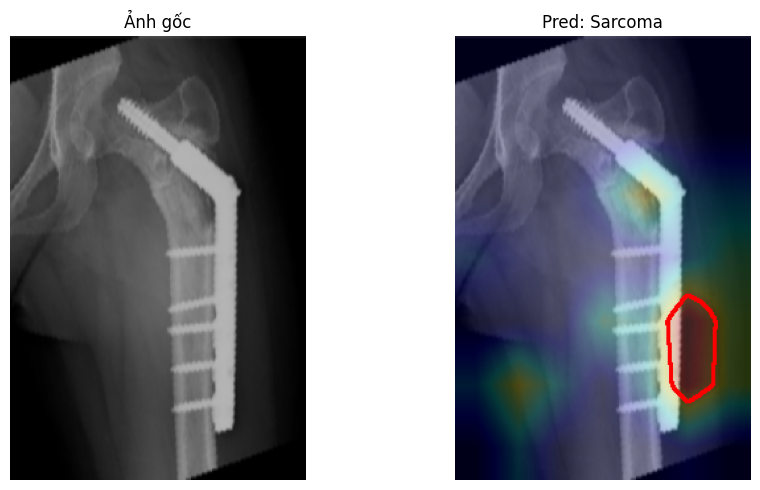

In [24]:
image_path = '/content/Đùi(P)4.png'
label_name=['Không bệnh','U sụn','Di căn','Sarcoma','U đại bào']
test(image_path, model_dui,label_name)

Trên tập tay

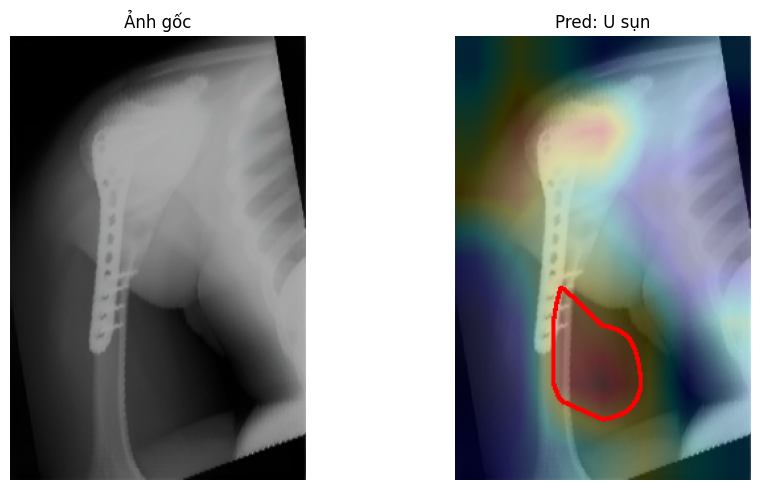

In [23]:
image_path ='/content/Tay(P)3.png'
label_name=['Không bệnh','Bọc xương ','U sụn','Sarcoma','U đại bào']
test(image_path, model_tay,label_name)

Trên tập chày

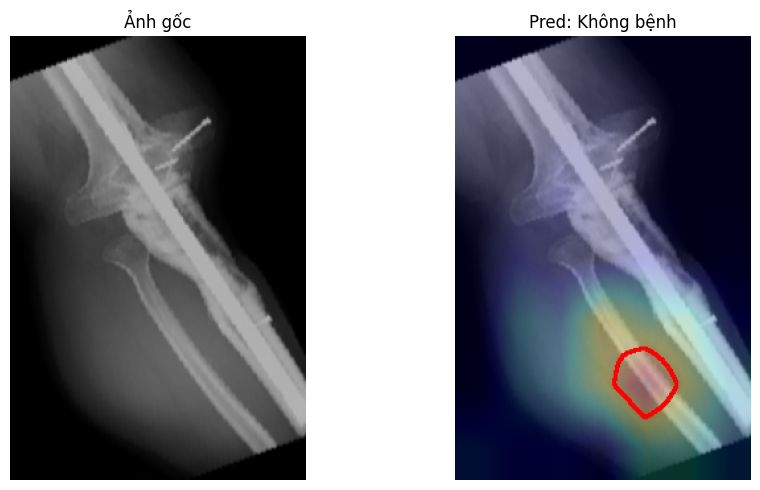

In [22]:
image_path = '/content/Chày(P)5.png'
label_name=['Không bệnh','Sarcoma','U đại bào']
test(image_path, model_chay,label_name)